<a href="https://colab.research.google.com/github/ravijoe/anomaly_detection_using_lstm/blob/master/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!pip install gdown
!pip install tensorflow-gpu

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Stored in directory: C:\Users\hp\AppData\Local\pip\Cache\wheels\eb\94\8d\73a58888096d6f5ca3070278a80292406cab5924e5da0d66a4
Successfully built gdown
  Using cached https://files.pythonhosted.org/packages/a3/de/c648ef6835192e6e2cc03f40b19eeda4382c49b5bafb43d88b931c4c74ac/google_pasta-0.2.0-py3-none-any.whl
  Found existing installation: h5py 2.9.0
    Uninstalling h5py-2.9.0:
      Successfully uninstalled h5py-2.9.0
  Found existing installation: google-pasta 0.1.7
    Uninstalling google-pasta-0.1.7:
      Successfully uninstalled google-pasta-0.1.7
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing

ERROR: tensorflow 2.1.1 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 2.1.1 has requirement tensorboard<2.2.0,>=2.1.0, but you'll have tensorboard 2.2.2 which is incompatible.
ERROR: tensorflow-probability 0.9.0 has requirement cloudpickle>=1.2.2, but you'll have cloudpickle 1.2.1 which is incompatible.
ERROR: tensorboard 2.2.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.24.1 which is incompatible.
ERROR: rasa 1.10.3 has requirement ruamel.yaml<0.17,>=0.16, but you'll have ruamel-yaml 0.15.46 which is incompatible.


referencess:- https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 32.4MB/s]


In [5]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [6]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


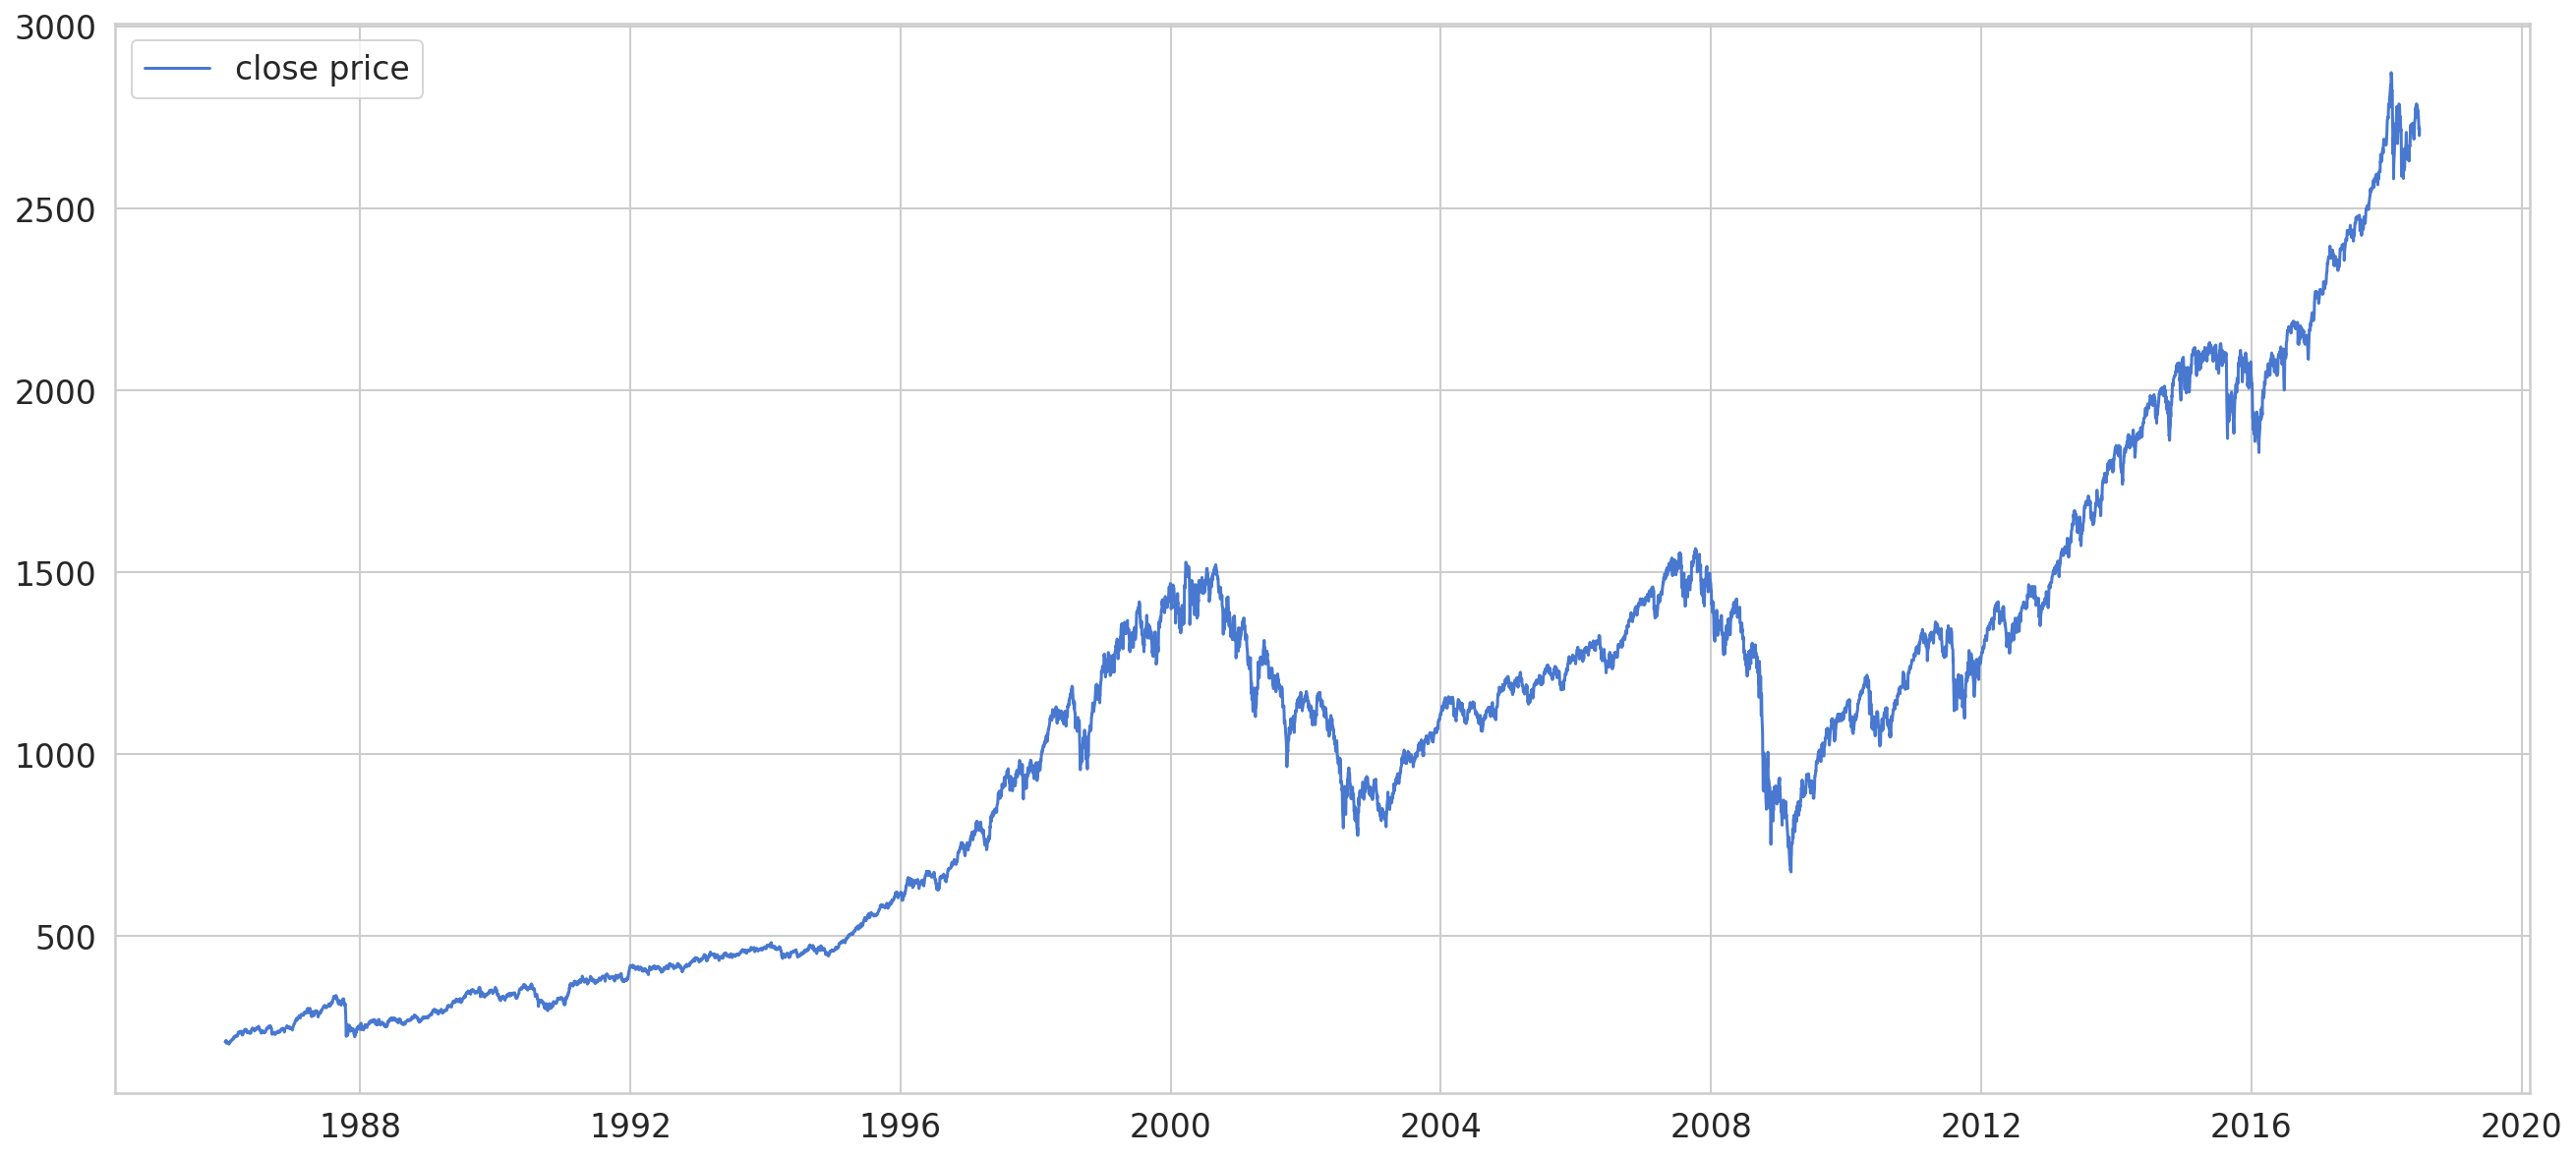

In [7]:
plt.plot(df, label='close price')
plt.legend();

In [8]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [10]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [11]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [12]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 5s 21ms/step - loss: 0.1691 - val_loss: 0.1823
Epoch 2/10
218/218 [==============================] - 4s 17ms/step - loss: 0.0935 - val_loss: 0.1604
Epoch 3/10
218/218 [==============================] - 4s 17ms/step - loss: 0.0965 - val_loss: 0.1284
Epoch 4/10
218/218 [==============================] - 4s 17ms/step - loss: 0.0880 - val_loss: 0.1054
Epoch 5/10
218/218 [==============================] - 4s 17ms/step - loss: 0.0918 - val_loss: 0.0656
Epoch 6/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1043 - val_loss: 0.0977
Epoch 7/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1006 - val_loss: 0.0766
Epoch 8/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1094 - val_loss: 0.0635
Epoch 9/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1030 - val_loss: 0.1164
Epoch 10/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1133 - val_lo

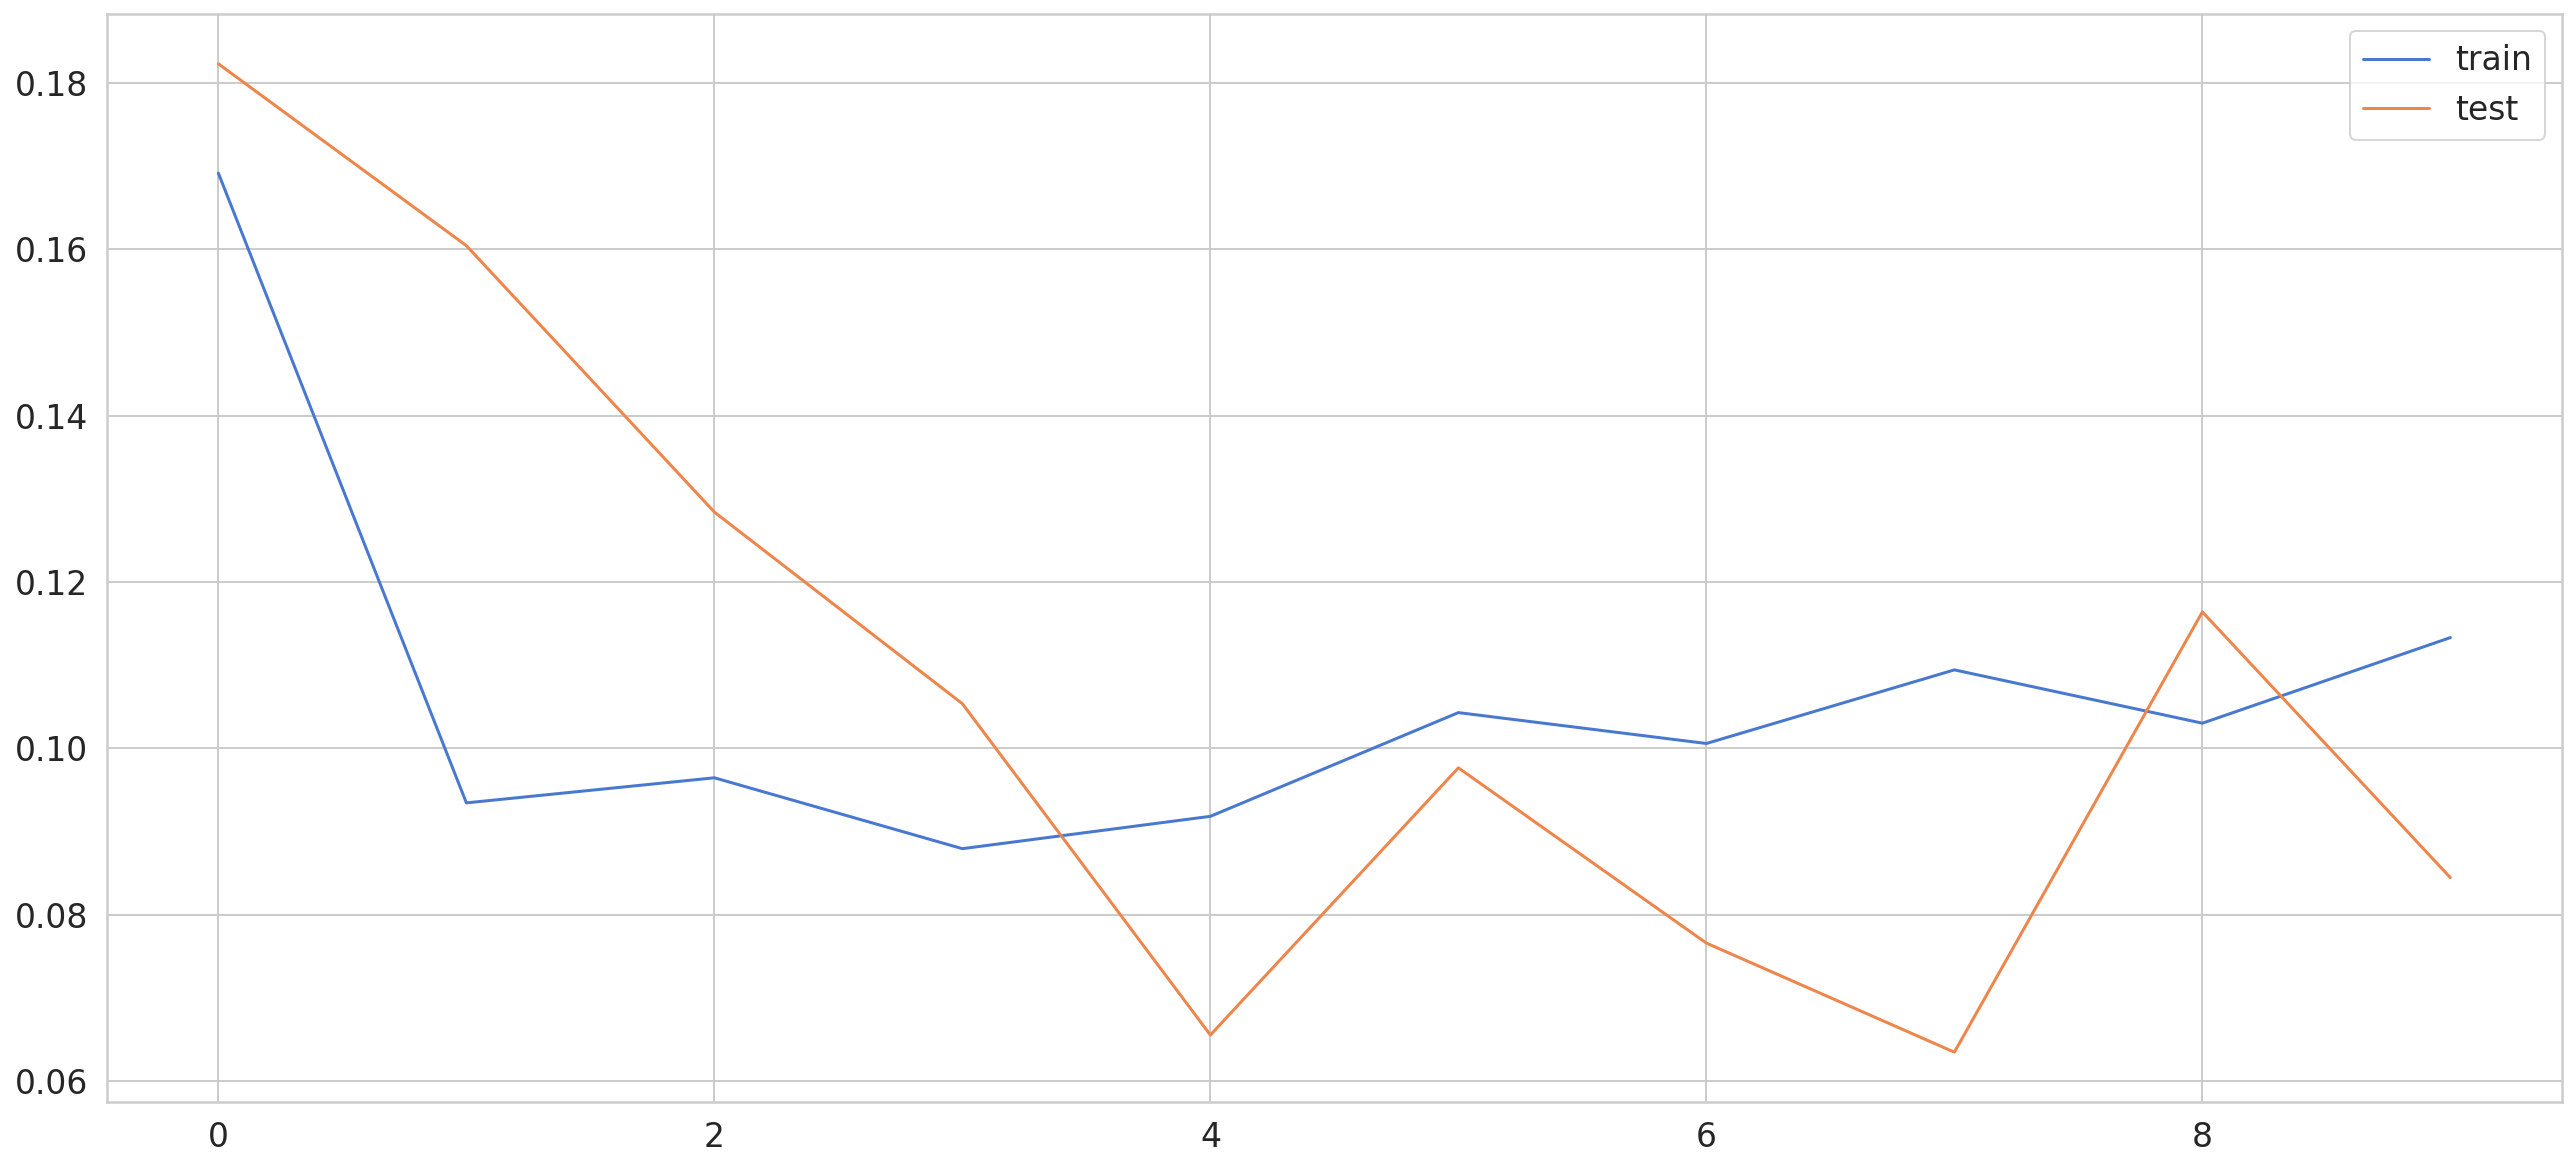

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [15]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

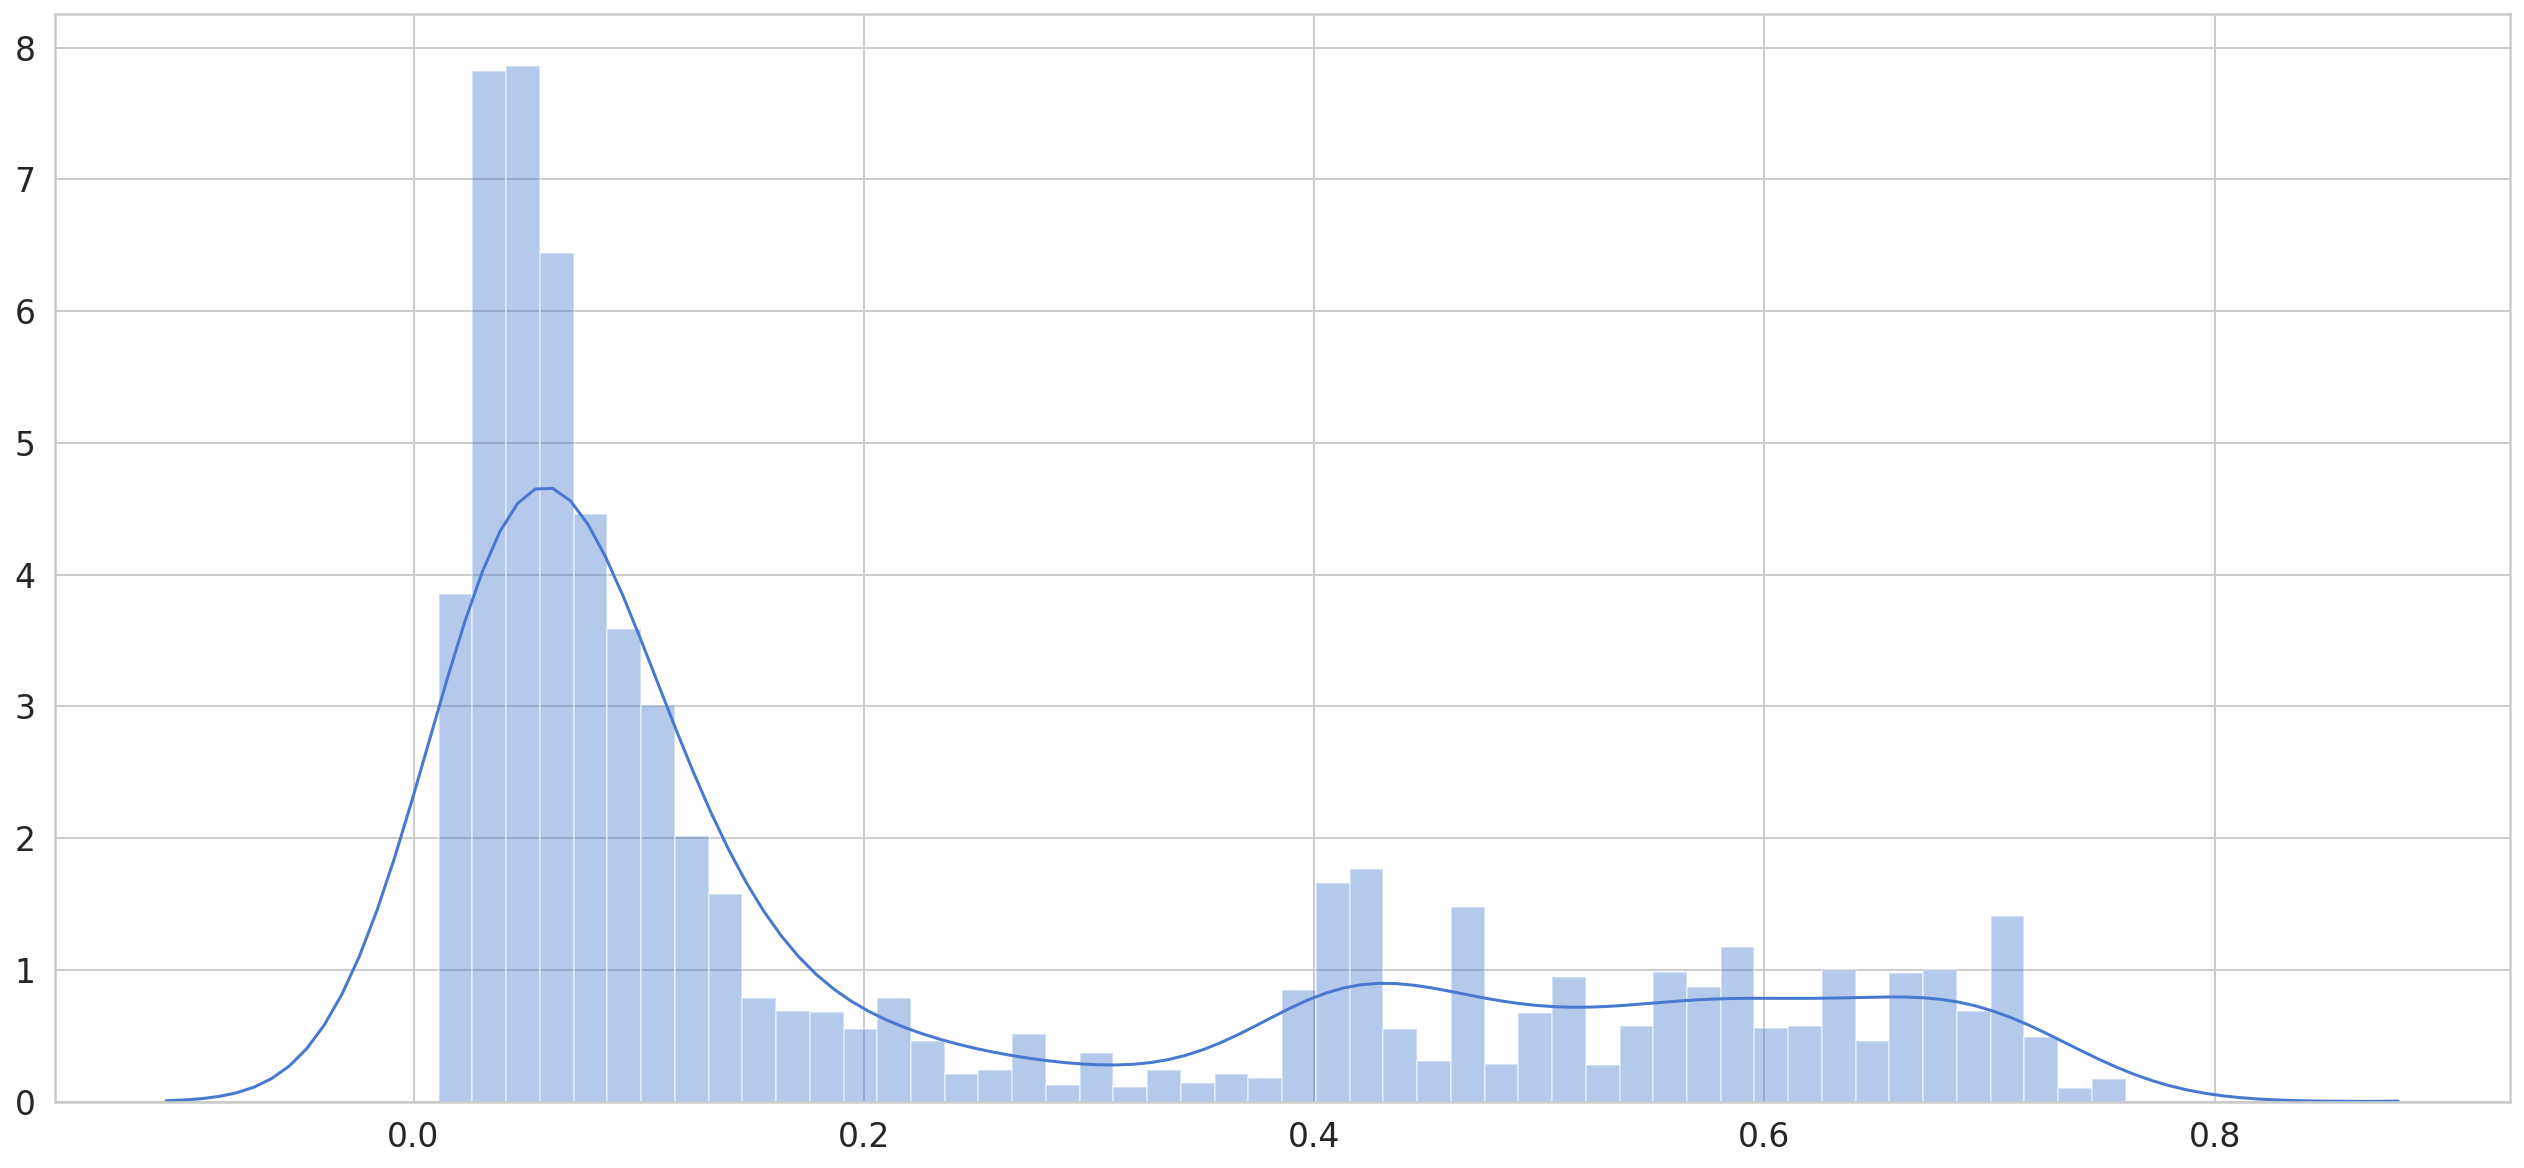

In [16]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [17]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [38]:
THRESHOLD = 0.42
# need to play around with threshold to decide optimal point as 
# threshold beyond which the point will be considered as anomaly
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

In [39]:
test_score_df

,loss,threshold,anomaly,close
date,,,,
2016-12-27,0.113995,0.42,False,2.392816
2016-12-28,0.115175,0.42,False,2.357204
2016-12-29,0.120605,0.42,False,2.355964
2016-12-30,0.127065,0.42,False,2.336373
2017-01-03,0.135102,0.42,False,2.372061
...,...,...,...,...
2018-06-25,0.327154,0.42,False,3.234646
2018-06-26,0.348405,0.42,False,3.245897
2018-06-27,0.358696,0.42,False,3.201889


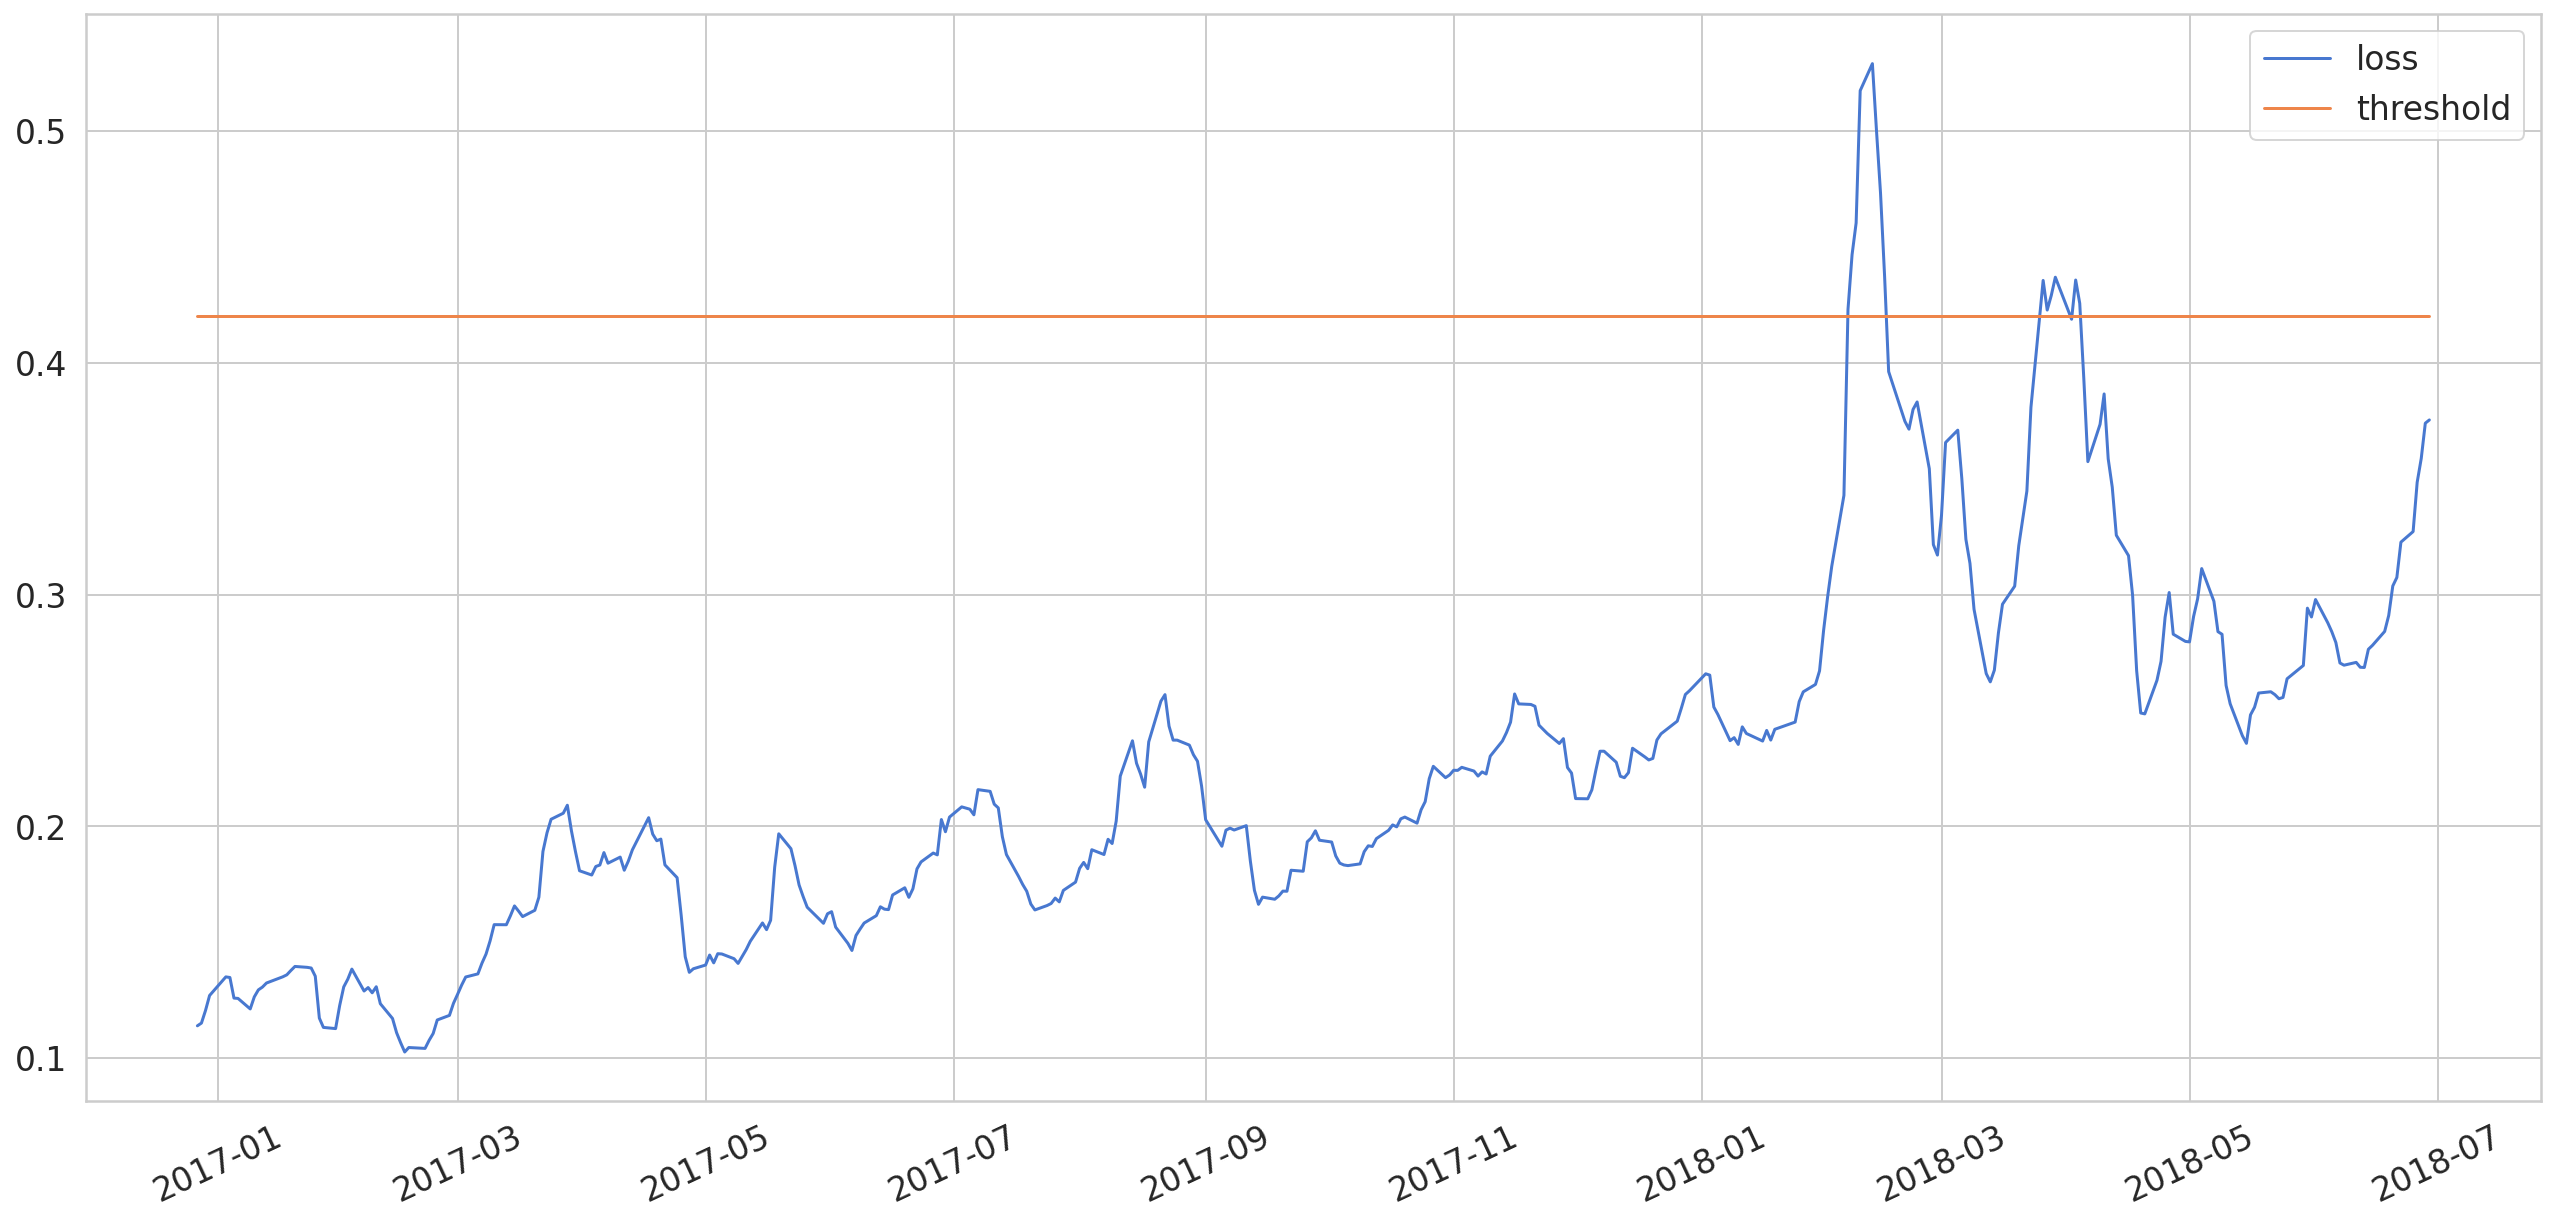

In [40]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [41]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-06,0.422982,0.42,True,3.193456
2018-02-07,0.446538,0.42,True,3.168136
2018-02-08,0.460261,0.42,True,2.979068
2018-02-09,0.517304,0.42,True,3.051476
2018-02-12,0.528959,0.42,True,3.119939


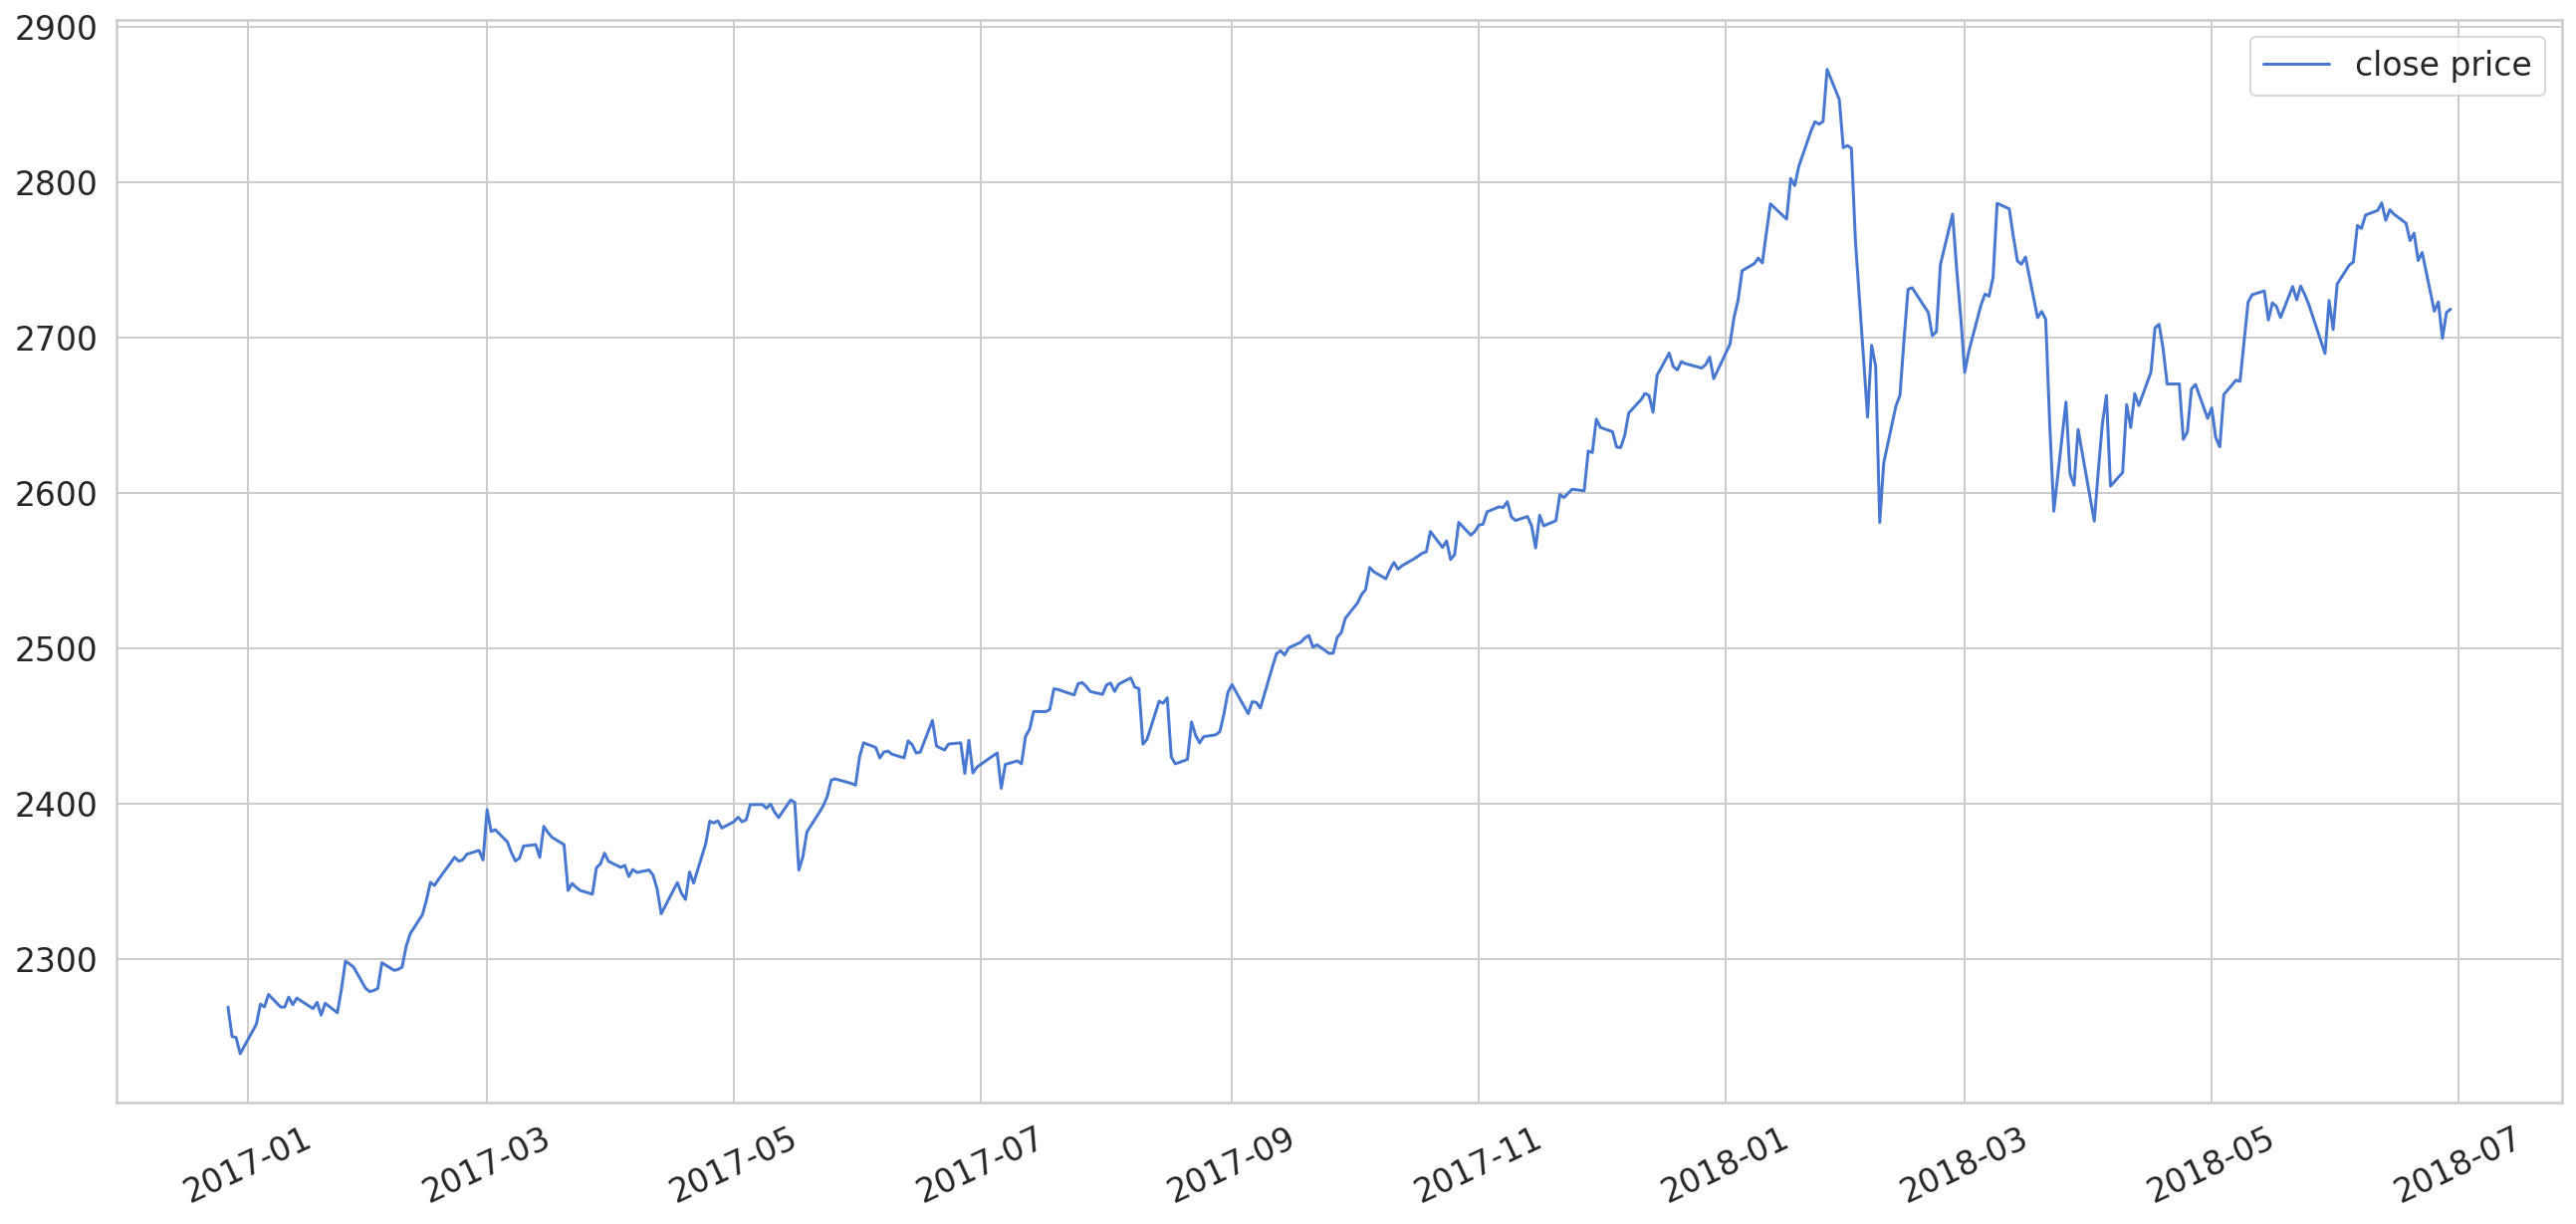

In [52]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

# sns.scatterplot(
#   anomalies.index,
#   scaler.inverse_transform(anomalies.close),
#   color=sns.color_palette()[3],
#   s=72,
#   label='anomaly'
# )
plt.xticks(rotation=25)
plt.legend();

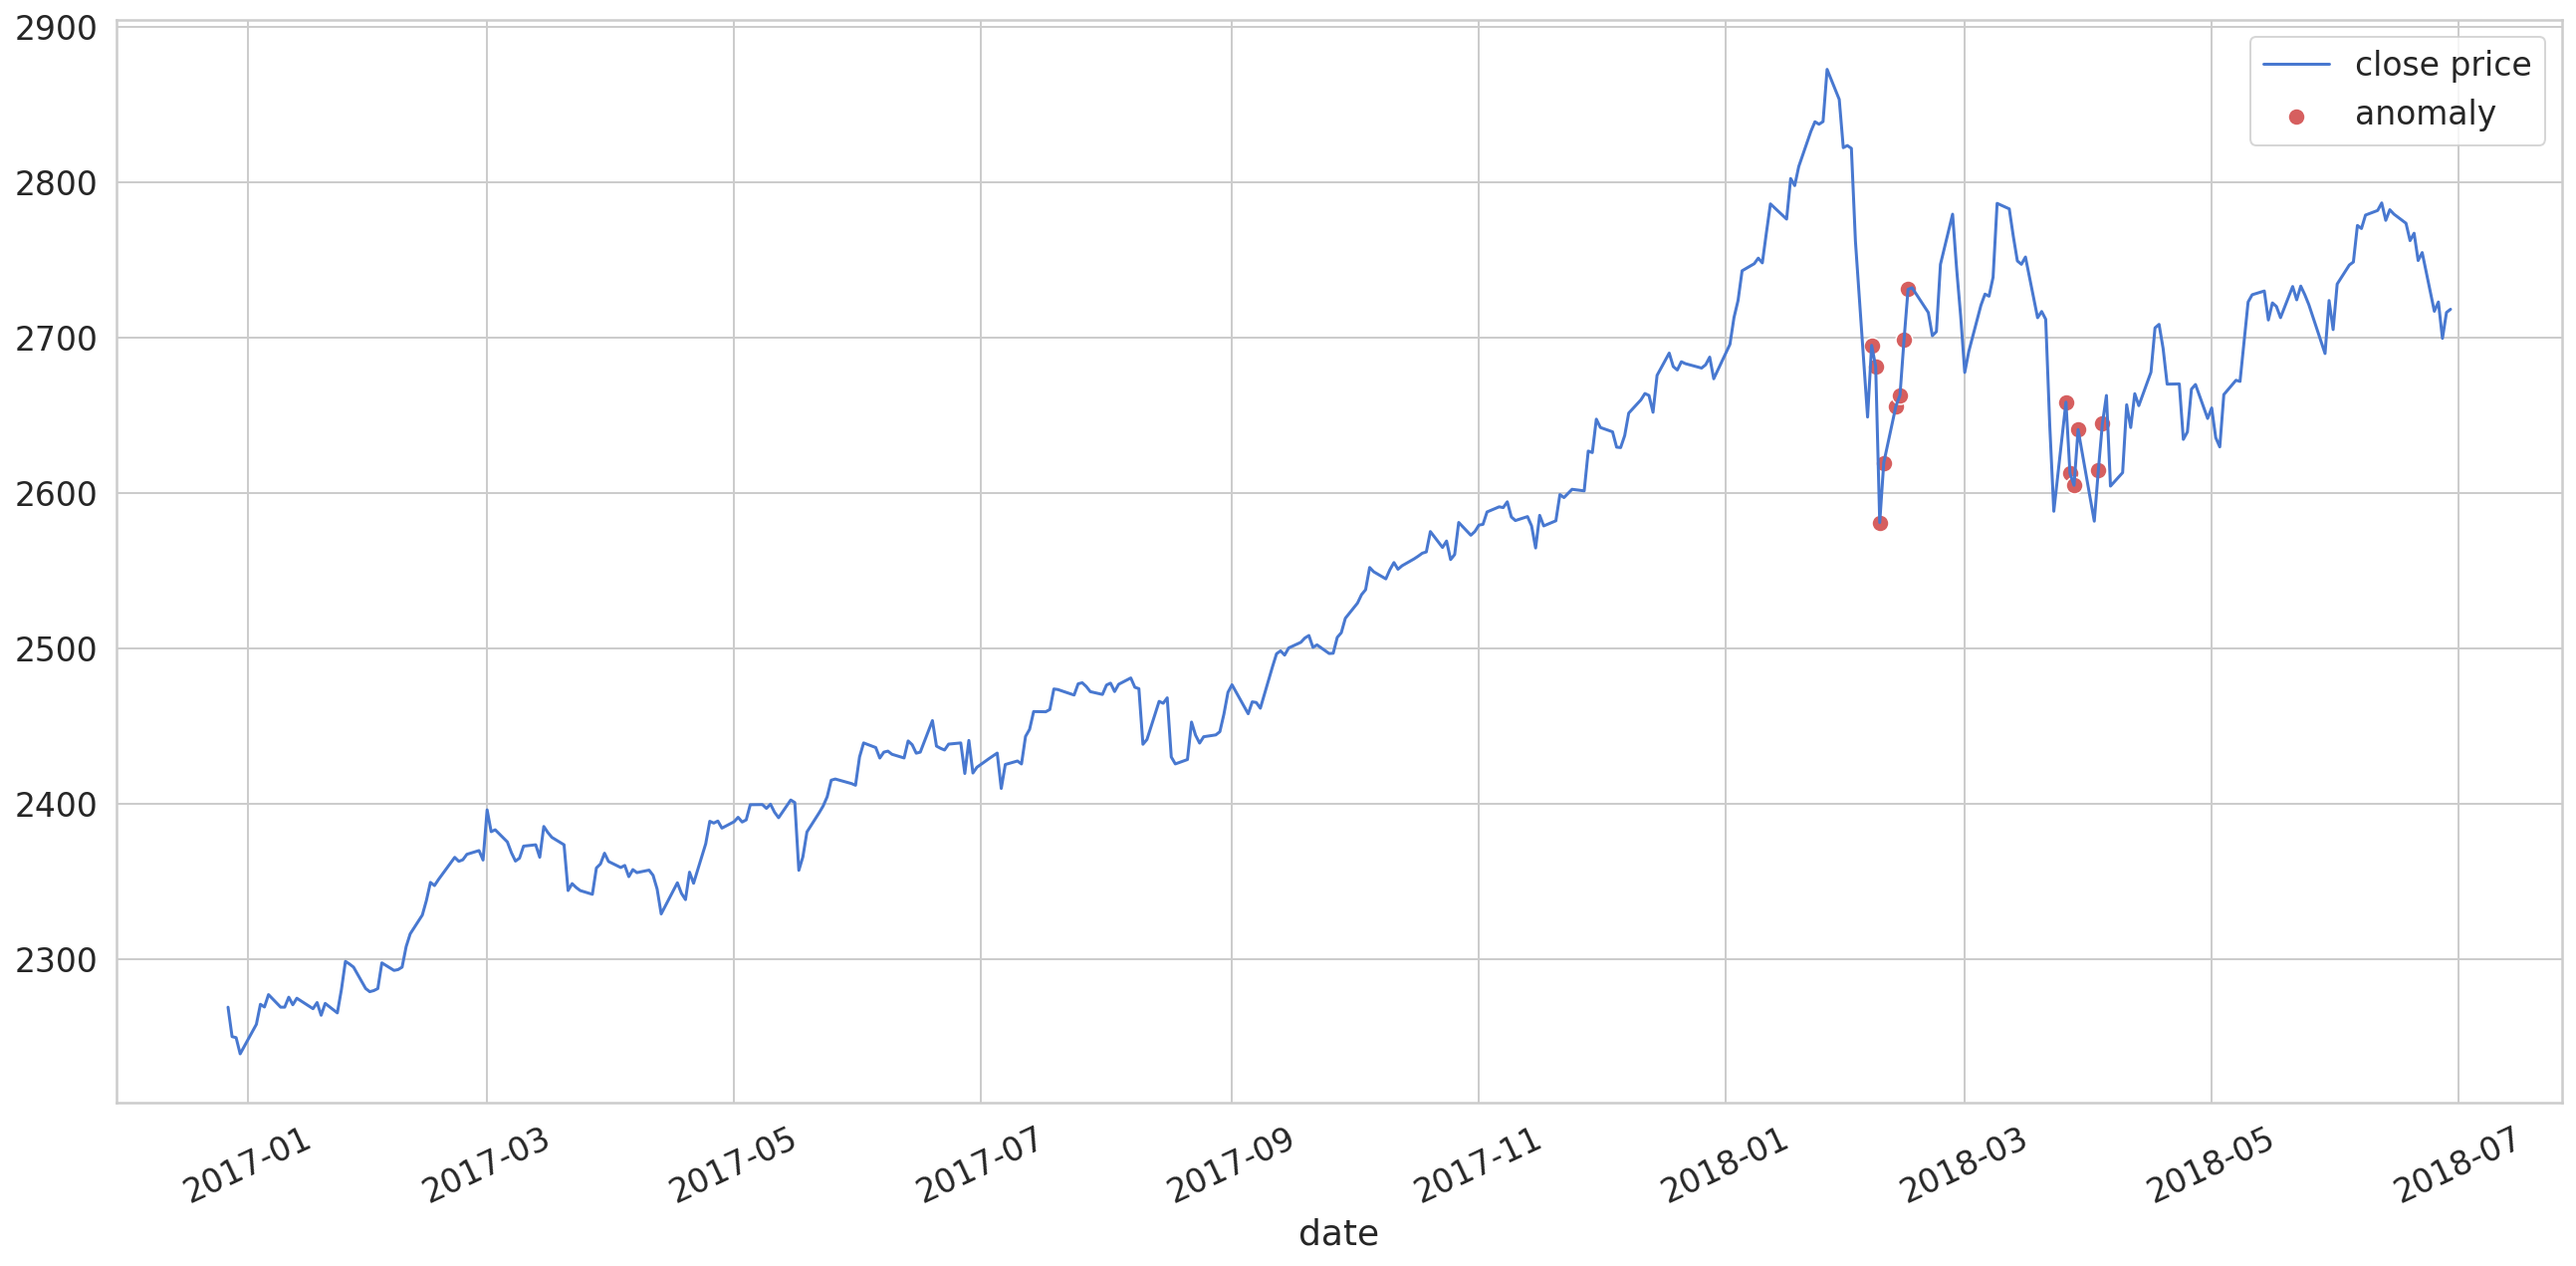

In [53]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=72,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();